# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# all imports
import time
import pickle
import csv
import operator
from itertools import groupby
from collections import OrderedDict

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

from utils2layers import *

In [2]:
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

classes = [i for i in range(44)]

X, Y = train['features'], train['labels']

X_test, y_test = test['features'], test['labels']

In [3]:
names = {}
with open('signnames.csv') as _f:
    rows = csv.reader(_f, delimiter=',')
    next(rows, None)  # skip the headers
    for row in rows:
        names[str(row[0])] = row[1]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
X_train, Y_train, X_val, Y_val = train_test_split(X, Y)

In [5]:
counts = {}

for i in range(len(Y_train)):
    cls = str(Y_train[i])
    if cls not in counts:
        counts[cls] = 1
    else:
        counts[cls] += 1

import operator
sorted_x = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
for k,v in sorted_x:
    counts[k] = (10000-v)

In [6]:
X_train = list(X_train)

Y_train = list(Y_train)

assert len(X_train) == len(Y_train), 'Unbalanced X, Y lengths'

length = len(X_train)

done = {}

for i in range(len(X_train)):
    cls = str(Y_train[i])
    if cls not in done:
        done[cls] = 0
    if i % 1000 == 0: print("jittering", cls, done[cls])
    for j in range(70):
        if counts[cls] == done[cls]:
            break
        done[cls] = done[cls] + 1 
        img = transform_image(X_train[i], 20, 10, 5)
        X_train.append(img)
        Y_train.append(int(cls))
        
X_train, Y_train = np.array(X_train), np.array(Y_train)

jittering 11 0
jittering 13 4060
jittering 40 1470
jittering 8 7910
jittering 12 8541
jittering 2 8411
jittering 25 8958
jittering 13 8512
jittering 1 8457
jittering 13 8512
jittering 12 8541
jittering 3 9010
jittering 3 9010
jittering 4 8627
jittering 38 8526
jittering 7 8997
jittering 26 9575
jittering 15 9549
jittering 0 6720
jittering 5 8707
jittering 38 8526
jittering 2 8411
jittering 2 8411
jittering 13 8512
jittering 12 8541
jittering 13 8512
jittering 1 8457
jittering 37 9851


In [7]:
counts = {}

for i in range(len(Y_train)):
    cls = str(Y_train[i])
    if cls not in counts:
        counts[cls] = 1
    else:
        counts[cls] += 1

print(counts)

{'37': 10000, '29': 10000, '23': 10000, '11': 10000, '10': 10000, '39': 10000, '40': 10000, '12': 10000, '41': 10000, '38': 10000, '19': 9798, '42': 10000, '0': 10000, '17': 10000, '13': 10000, '33': 10000, '6': 10000, '16': 10000, '21': 10000, '24': 10000, '18': 10000, '34': 10000, '35': 10000, '27': 10000, '5': 10000, '31': 10000, '36': 10000, '2': 10000, '14': 10000, '8': 10000, '32': 10000, '30': 10000, '1': 10000, '25': 10000, '22': 10000, '3': 10000, '9': 10000, '15': 10000, '26': 10000, '7': 10000, '4': 10000, '20': 10000, '28': 10000}


In [ ]:
data = group_classes(list(Y))
plot_frequency(list(names.values()), np.array(list(set(Y))), list(data.values()))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
Y_train = dense_to_one_hot(Y_train, num_classes)

Y_val = dense_to_one_hot(Y_val, num_classes)

Y_test =  dense_to_one_hot(y_test, num_classes)

In [9]:
# Image Tensor
images_placeholder = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')

gray = tf.image.rgb_to_grayscale(images_placeholder, name='gray')

gray /= 255.

# Label Tensor
labels_placeholder = tf.placeholder(tf.float32, shape=(None, 43), name='y')

# dropout Tensor
keep_prob = tf.placeholder(tf.float32, name='drop')

# construct model
logits = inference(gray, keep_prob)

# calculate loss
loss_value = loss(logits, labels_placeholder)

# predictions = tf.nn.softmax(logits)

# training
train_op = training(loss_value, 0.0001)

# accuracy
acc, y_pred_cls = accuracy(logits, labels_placeholder)

saver = tf.train.Saver()

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.merge_all_summaries()

In [10]:
steps = len(X_train) // BATCH_SIZE
    
train_num_examples = steps * BATCH_SIZE

In [11]:
def evaluate(X_data, y_data):
    Predictions = list()
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    acc_steps = len(X_data) // BATCH_SIZE
    for i in range(acc_steps):
        batch_x, batch_y = next_batch(X_data, y_data, BATCH_SIZE)
                   
        summary, loss, accuracy, predictions = sess.run([merged, loss_value, acc, y_pred_cls], feed_dict={
                images_placeholder: batch_x,
                labels_placeholder: batch_y,
                keep_prob: 1.
                })
        Predictions.append(predictions)
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
        
    return (summary, total_accuracy / num_examples, total_loss / num_examples, Predictions)

In [12]:
with tf.Session() as sess:
    
    sess.run(tf.initialize_all_variables())
    train_writer = tf.train.SummaryWriter('/home/ubuntu/train', sess.graph)
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for j in range(steps):
            # train for batch_size
            batch_x, batch_y = next_batch(X_train, Y_train, BATCH_SIZE)
            sess.run(train_op, feed_dict={
                images_placeholder: batch_x,
                labels_placeholder: batch_y,
                keep_prob: 0.5})
            
        summary, val_accuracy, val_loss, predictions = evaluate(X_val, Y_val)
        train_writer.add_summary(summary, i)
        print("EPOCH {} ...".format(i+1))
        print("Validation Loss = {:.3f} and Validation Accuracy = {:.3f}".format(val_loss, val_accuracy*100))

    save_path = saver.save(sess, '/home/ubuntu/gtsd-final.chkpt')
    print("Model saved in file: %s" % save_path)

Training...

EPOCH 1 ...
Validation Loss = 10.372 and Validation Accuracy = 1.819
EPOCH 2 ...
Validation Loss = 1.290 and Validation Accuracy = 62.680
EPOCH 3 ...
Validation Loss = 0.820 and Validation Accuracy = 77.455
EPOCH 4 ...
Validation Loss = 0.567 and Validation Accuracy = 85.029
EPOCH 5 ...
Validation Loss = 0.404 and Validation Accuracy = 89.042
EPOCH 6 ...
Validation Loss = 0.293 and Validation Accuracy = 92.000
EPOCH 7 ...
Validation Loss = 0.224 and Validation Accuracy = 93.667
EPOCH 8 ...
Validation Loss = 0.172 and Validation Accuracy = 95.180
EPOCH 9 ...
Validation Loss = 0.138 and Validation Accuracy = 96.055
EPOCH 10 ...
Validation Loss = 0.110 and Validation Accuracy = 96.710
EPOCH 11 ...
Validation Loss = 0.091 and Validation Accuracy = 97.246
EPOCH 12 ...
Validation Loss = 0.077 and Validation Accuracy = 97.569
EPOCH 13 ...
Validation Loss = 0.067 and Validation Accuracy = 97.688
EPOCH 14 ...
Validation Loss = 0.056 and Validation Accuracy = 98.053
EPOCH 15 ...
Val

In [13]:
test_batch_size = 32 

img_shape = (32, 32, 3)

def plot_images(images, cls_true, cls_pred=None):
#     assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), np.argmax(cls_pred[i]))

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def plot_example_errors(cls_pred, correct, X_data, Y_data):
    
    incorrect = np.array(correct == False)
    print(incorrect)
    images = X_data[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = Y_data[incorrect]

    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])


def print_test_accuracy(session, predictions, X_data, Y_data):

    num_test = len(predictions)
    _placeholder = tf.placeholder(tf.float32, shape=(None, 43))
    _predictions = tf.placeholder(tf.int64, shape=(num_test,))
    _true = tf.argmax(_placeholder, 1)
    _correct = tf.equal(_true, _predictions)
    cls_true, correct = sess.run([_true, _correct], feed_dict={_placeholder:Y_data, _predictions: predictions})

    correct_sum = correct.sum()

    _acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: ({} / {})"
    print(msg.format(correct_sum, num_test))


    print("Example errors:")
    plot_example_errors(predictions, correct, X_data, Y_data)


Model restored.
Test Accuracy = 95.796
Accuracy on Test-Set: (434 / 12608)
Example errors:
[ True  True  True ...,  True  True  True]


/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12630 but corresponding boolean dimension is 12608


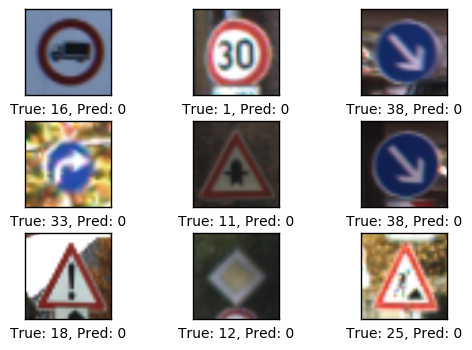

In [15]:
with tf.Session() as sess:
    saver.restore(sess, '/home/ubuntu/gtsd-final.chkpt')
    print("Model restored.")
    summary, test_accuracy, test_loss, predictions = evaluate(X_test, Y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy*100))
    predictions = np.array([item for sublist in predictions for item in sublist])
    print_test_accuracy(sess, predictions, X_test, np.array(list(Y_test)[:-22]))
    

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

For preprocessing I explored several options.  

1) Using RGB

Using RGB only yielded a 70% or so validation accuracy

2) Using YUV

Many of the images are very dark.  I converted the images to YUV and brightened the Y channel but using this same model I was only able to get 88% validation accuracy

3) Just Grayscaling

With the above model and just grayscaling I saw the highest validation accuracy of 93%

All images were of course normalized to reduce computational by dividing each pixel by the value `255`.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Having read LeCuN's paper on this task, I decided to Jitter each image in the dataset to account for potential deformations in the test set.  This improved validation accuracy from 86 to 99%.

To create the validation set, I used Sklearn to take 30% of the test set for validation.  


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


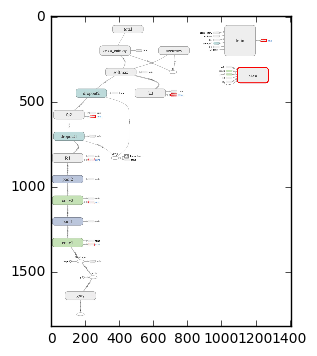

In [16]:
img = cv2.imread('Model.jpg', 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='binary')

**Answer:**

Full Model details are:

1) 2 conv layers of 5x5 kernel sizes

2) 2x2 pooling 

3) 2 FC layers each 0.5 dropped




    

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_



**Answer:**

Optimizer: Adam

Epochs: Max of 100

Batch Size: 32


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I began with a trial and error process which is far too involved for a short answer.  After reading the lecture notes for CS231n, the biggest takeaway for me where the forumulas:

`(W−F+2P)/S+1`

and

`P=(F−1)/2`
 
 Having understood that ConvNets do not fully connect on each layer and only through the depth dimension, I attempted to balance the width and heigths dimensions through the first convolution with a patch of 3, a filter size of 32, a stride of 2, and 2x2 pooling.
 
 This improved my model drastically.  I still had one other implementation issue:  
 
 I pieced together this code from multiple google searches.  At one point I had code which took the softmax, then a few lines of code later used softmax_with_logits.  While this gave reasonable accuracy of 94% I knew it couldn't be trusted because the loss was not reasonable.
 
 Removing the `sofmax` and only using `sofmax_with_logits` solved this problem and I consistently received higher than `92%` with this model on each subsequent trial.
 
 Accuracy on the test set was always above `95.5%`
 
 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [17]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
from PIL import Image
names = os.listdir('./downloaded-images')
images = [cv2.imread('./downloaded-images/'+img, 1) for img in names]
classes = [int(img.replace('.jpg', '')) for img in names]

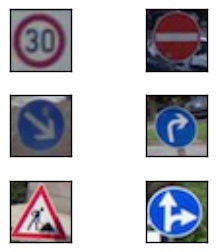

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(3, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB), cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])

In [19]:
X_downloaded = images
y_downloaded = list()
for _cls in classes:
    y = np.zeros(43, dtype=np.uint8)
    y[_cls] = 1.
    y_downloaded.append(y)

y_downloaded = np.array(y_downloaded)

In [20]:
def evaluate_downloaded(X_data, y_data):
    Predictions = list()
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()

 
    loss, accuracy, predictions = sess.run([loss_value, acc, y_pred_cls], feed_dict={
                images_placeholder: X_data,
                labels_placeholder: y_data,
                keep_prob: 1.
                })

        
    return loss, accuracy, [predictions]



In [21]:

with tf.Session() as sess:
    saver.restore(sess, '/home/ubuntu/gtsd-final.chkpt')
    print("Model restored.")
    test_loss, test_accuracy, predictions = evaluate_downloaded(X_downloaded, y_downloaded)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    predictions = np.array([item for sublist in predictions for item in sublist])
    print(predictions)
    

Model restored.
Test Accuracy = 1.000
[ 1 17 38 33 25 36]


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



In [ ]:
data = group_classes_sorted(sorted(Y_train))
images, labels, counts = get_images_and_counts(X, list(Y), data)
plot_signs(images, labels, counts)

**Answer:**

There are certainly many brightness issues that can affect the classification.  There are also some images that have more than one sign in them, which increases difficulty even more.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [22]:
img = cv2.imread('crossentropy.jpg', 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='binary')

error: /home/travis/miniconda/conda-bld/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7341: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.